In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.applications.xception import Xception

import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("./input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['internship_data.tar.gz']
Python       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


In [3]:
!pip freeze > requirements.txt

In [4]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 2  # количество классов в нашей задаче
IMG_SIZE             = 128 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = './input/'
PATH = "./" # рабочая директория

In [5]:
# Устаналиваем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

### EDA / Анализ данных

In [6]:
import tarfile
tar = tarfile.open("./input/internship_data.tar.gz")
tar.extractall(PATH)
tar.close()

In [7]:
print(os.listdir(PATH+'internship_data'))

['female', 'male']


In [8]:
df_female = pd.DataFrame(os.listdir(PATH+'internship_data'+'/female'), columns = ['Id'])
df_female['Category'] = 'female'
df_male = pd.DataFrame(os.listdir(PATH+'internship_data'+'/male'), columns = ['Id'])
df_male['Category'] = 'male'

In [9]:
df = pd.concat([df_female, df_male], ignore_index=True)

Пример картинок female(random sample)


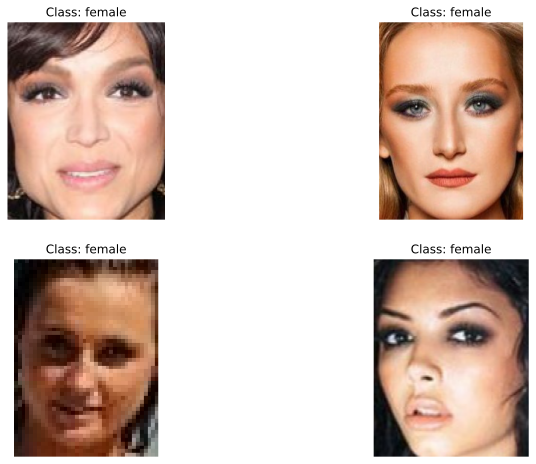

In [10]:
print('Пример картинок female(random sample)')
plt.figure(figsize=(12,8))

random_image = df_female.sample(n=4)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'internship_data/{random_image_cat[index]}/{path}')
    plt.subplot(2,2, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок male(random sample)


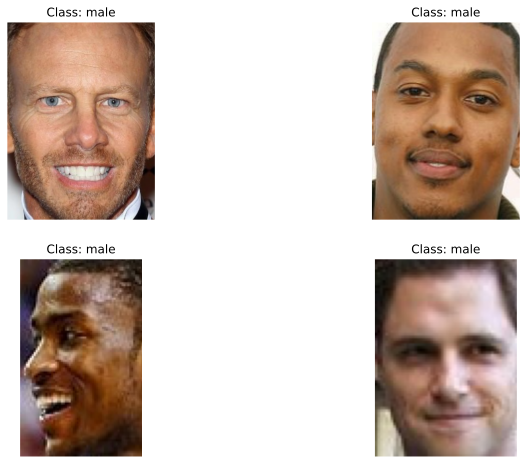

In [11]:
print('Пример картинок male(random sample)')
plt.figure(figsize=(12,8))

random_image = df_male.sample(n=4)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'internship_data/{random_image_cat[index]}/{path}')
    plt.subplot(2,2, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.     

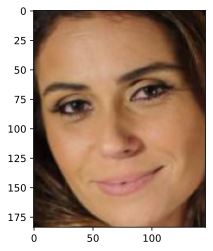

(146, 184)

In [12]:
image = PIL.Image.open(PATH+'/internship_data/female/053485.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [13]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((80003, 2), (20001, 2))

In [14]:
train_files['Category'].value_counts()

male      40002
female    40001
Name: Category, dtype: int64

In [15]:
test_files['Category'].value_counts()

female    10001
male      10000
Name: Category, dtype: int64

In [17]:
root = PATH+'internship_data'
#Ячейка для переноса изображений в одну папку. Выполняется один раз
from os.path import join
from os import listdir, rmdir
from shutil import move

for filename in listdir(join(root, 'female')):
    move(join(root, 'female', filename), join(root, filename))
rmdir(root+'/female')

for filename in listdir(join(root, 'male')):
    move(join(root, 'male', filename), join(root, filename))
rmdir(root+'/male')

In [18]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [19]:
train_generator = train_datagen.flow_from_dataframe (dataframe = train_files, directory = root, x_col = "Id", 
                                               y_col = "Category", class_mode = "categorical", 
                                               target_size = (IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,shuffle=True, 
                                               seed=RANDOM_SEED)

test_generator = test_datagen.flow_from_dataframe (dataframe = test_files, directory = root, x_col = "Id", 
                                               y_col = "Category", class_mode = "categorical", 
                                               target_size = (IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,shuffle=True, 
                                               seed=RANDOM_SEED)

/home/mikhail/anaconda3/envs/project/env/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="Id". These filename(s) will be ignored.
  warnings.warn(


Found 80001 validated image filenames belonging to 2 classes.
Found 20001 validated image filenames belonging to 2 classes.


Пример картинок из train_generator


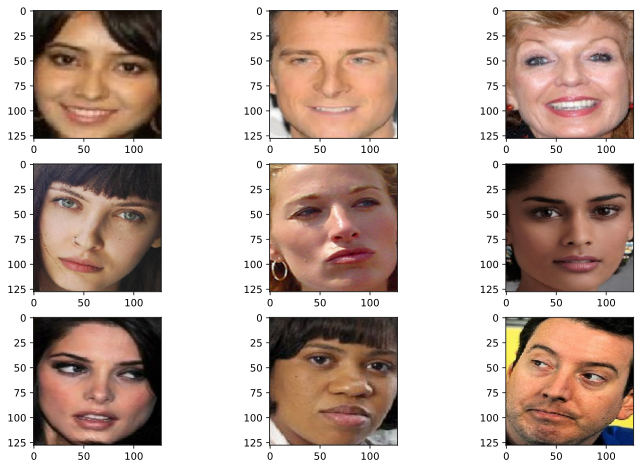

In [20]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


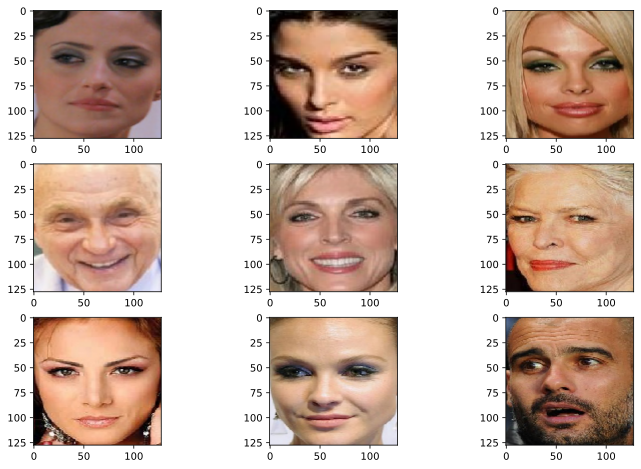

In [21]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [22]:
import efficientnet.tfkeras as efn
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [53]:
base_model.trainable = False

In [12]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [14]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [37]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [57]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

313/313 [==============================] - 615s 2s/step - loss: 0.6907 - accuracy: 0.5398
Accuracy: 53.98%


In [58]:
# Обучаем
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = test_generator, 
                    validation_steps = test_generator.samples//test_generator.batch_size,
                    epochs = 5,
                    callbacks = callbacks_list
                    )

Epoch 1/5
1250/1250 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.8868
Epoch 00001: saving model to best_model.hdf5
1250/1250 [==============================] - 3316s 3s/step - loss: 0.2770 - accuracy: 0.8868 - val_loss: 0.2211 - val_accuracy: 0.9149
Epoch 2/5
1250/1250 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.8995
Epoch 00002: saving model to best_model.hdf5
1250/1250 [==============================] - 3401s 3s/step - loss: 0.2470 - accuracy: 0.8995 - val_loss: 0.2010 - val_accuracy: 0.9197
Epoch 3/5
1250/1250 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9016
Epoch 00003: saving model to best_model.hdf5
1250/1250 [==============================] - 3366s 3s/step - loss: 0.2374 - accuracy: 0.9016 - val_loss: 0.1925 - val_accuracy: 0.9253
Epoch 4/5
1250/1250 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9045
Epoch 00004: saving model to best_model.hdf5
1250/1250 [================

### Cохранение модели

In [59]:
model.save('../model_last.hdf5')
model.load_weights('best_model.hdf5')

In [60]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

313/313 [==============================] - 680s 2s/step - loss: 0.1880 - accuracy: 0.9265
Accuracy: 92.65%


### Загрузка модели

In [23]:
import efficientnet.tfkeras as efn
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [24]:
base_model.trainable = False

In [25]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [26]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [27]:
model.load_weights('best_model.hdf5')

In [28]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
313/313 [==============================] - 601s 2s/step - loss: 0.1881 - accuracy: 0.9266
Accuracy: 92.66%
